# Feature Engineering Notebook

## Objectives

* Perform Correlation and PPS Analysis
* Engineer features for ML models

## Inputs

* outputs/datasets/cleaned/FertilityTreatmentDataCleaned.csv
* outputs/datasets/cleaned/TestSetCleaned.csv
* outputs/datasets/cleaned/TrainSetCleaned.csv

## Outputs

* generate a list with variables to engineer

## Conclusions

* Feature Engineering Transformers





---

# Change working directory

Change the working directory from its current folder to its parent folder
* Access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/Users/patriciahalley/Documents/Code_institute/git/ivf-success-predictor/jupyter_notebooks'

To make the parent of the current directory the new current directory:
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("A new current directory has been set")

A new current directory has been set


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/Users/patriciahalley/Documents/Code_institute/git/ivf-success-predictor'

---

# Load cleaned data

In [4]:
import pandas as pd
# Read the DataFrame from the compressed CSV file
df = pd.read_csv('outputs/datasets/cleaned/FertilityTreatmentDataCleaned.csv')
df.head(3)

Patient age at treatment Total number of previous IVF cycles  \
0                    38-39                                   3   
1                    18-34                                   0   
2                    38-39                                   2   

  Total number of previous DI cycles  \
0                                  0   
1                                  0   
2                                  0   

   Total number of previous pregnancies - IVF and DI  \
0                                                  0   
1                                                  0   
2                                                  0   

   Total number of previous live births - IVF or DI  \
0                                                 0   
1                                                 0   
2                                                 0   

   Causes of infertility - tubal disease  \
0                                      0   
1                                      0   
2                                      0   

   Causes of infertility - ovulatory disorder  \
0                                           0   
1                                           0   
2                                           0   

   Causes of infertility - male factor  \
0                                    1   
1                                    1   
2                                    0   

   Causes of infertility - patient unexplained  \
0                                            0   
1                                            0   
2                                            1   

   Causes of infertility - endometriosis  ...  Total eggs mixed  \
0                                      0  ...             11-15   
1                                      0  ...               1-5   
2                                      0  ...               1-5   

  Total embryos created Embryos transferred Total embryos thawed  \
0                  6-10                   2      0 - fresh cycle   
1                   1-5                  1e      0 - fresh cycle   
2                     0                   0      0 - fresh cycle   

   Embryos transferred from eggs micro-injected  Date of embryo transfer  \
0                                             2                5 - fresh   
1                                             1                4 - fresh   
2                                             0                       NT   

   Live birth occurrence Patient ethnicity Partner ethnicity  Partner age  
0                      1             White             White        43-44  
1                      0             White             White        18-34  
2                      0             Other             Other        35-37  

[3 rows x 32 columns]

### Correlation and PPS Analysis

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ppscore as pps
import warnings
warnings.filterwarnings("ignore")

def heatmap_corr(df, threshold, figsize=(20, 12), font_annot=8):
    if len(df.columns) > 1:
        mask = np.zeros_like(df, dtype=bool)
        mask[np.triu_indices_from(mask)] = True
        mask[abs(df) < threshold] = True

        fig, axes = plt.subplots(figsize=figsize)
        sns.heatmap(df, annot=True, xticklabels=True, yticklabels=True,
                    mask=mask, cmap='viridis', annot_kws={"size": font_annot}, ax=axes,
                    linewidth=0.5
                    )
        axes.set_yticklabels(df.columns, rotation=0)
        plt.ylim(len(df.columns), 0)
        plt.show()


def heatmap_pps(df, threshold, figsize=(20, 12), font_annot=8):
    if len(df.columns) > 1:
        mask = np.zeros_like(df, dtype=bool)
        mask[abs(df) < threshold] = True
        fig, ax = plt.subplots(figsize=figsize)
        ax = sns.heatmap(df, annot=True, xticklabels=True, yticklabels=True,
                         mask=mask, cmap='rocket_r', annot_kws={"size": font_annot},
                         linewidth=0.05, linecolor='grey')
        plt.ylim(len(df.columns), 0)
        plt.show()


def CalculateCorrAndPPS(df):
    df_corr_spearman = df.corr(method="spearman", numeric_only=True)
    df_corr_pearson = df.corr(method="pearson", numeric_only=True)

    pps_matrix_raw = pps.matrix(df)
    pps_matrix = pps_matrix_raw.filter(['x', 'y', 'ppscore']).pivot(columns='x', index='y', values='ppscore')

    pps_score_stats = pps_matrix_raw.query("ppscore < 1").filter(['ppscore']).describe().T
    print("PPS threshold - check PPS score IQR to decide threshold for heatmap \n")
    print(pps_score_stats.round(3))

    return df_corr_pearson, df_corr_spearman, pps_matrix


def DisplayCorrAndPPS(df_corr_pearson, df_corr_spearman, pps_matrix, CorrThreshold, PPS_Threshold,
                      figsize=(20, 12), font_annot=8):

    print("\n")
    print("* Analyse how the target variable for your ML models are correlated with other variables (features and target)")
    print("* Analyse multi-colinearity, that is, how the features are correlated among themselves")

    print("\n")
    print("*** Heatmap: Spearman Correlation ***")
    print("It evaluates monotonic relationship \n")
    heatmap_corr(df=df_corr_spearman, threshold=CorrThreshold, figsize=figsize, font_annot=font_annot)

    print("\n")
    print("*** Heatmap: Pearson Correlation ***")
    print("It evaluates the linear relationship between two continuous variables \n")
    heatmap_corr(df=df_corr_pearson, threshold=CorrThreshold, figsize=figsize, font_annot=font_annot)

    print("\n")
    print("*** Heatmap: Power Predictive Score (PPS) ***")
    print(f"PPS detects linear or non-linear relationships between two columns.\n"
          f"The score ranges from 0 (no predictive power) to 1 (perfect predictive power) \n")
    heatmap_pps(df=pps_matrix, threshold=PPS_Threshold, figsize=figsize, font_annot=font_annot)


Calculate Correlations and Power Predictive Score

In [6]:
df_corr_pearson, df_corr_spearman, pps_matrix = CalculateCorrAndPPS(df)

PPS threshold - check PPS score IQR to decide threshold for heatmap 

         count   mean    std  min  25%  50%  75%    max
ppscore  992.0  0.063  0.195  0.0  0.0  0.0  0.0  0.999


Display Heatmaps



* Analyse how the target variable for your ML models are correlated with other variables (features and target)
* Analyse multi-colinearity, that is, how the features are correlated among themselves


*** Heatmap: Spearman Correlation ***
It evaluates monotonic relationship 



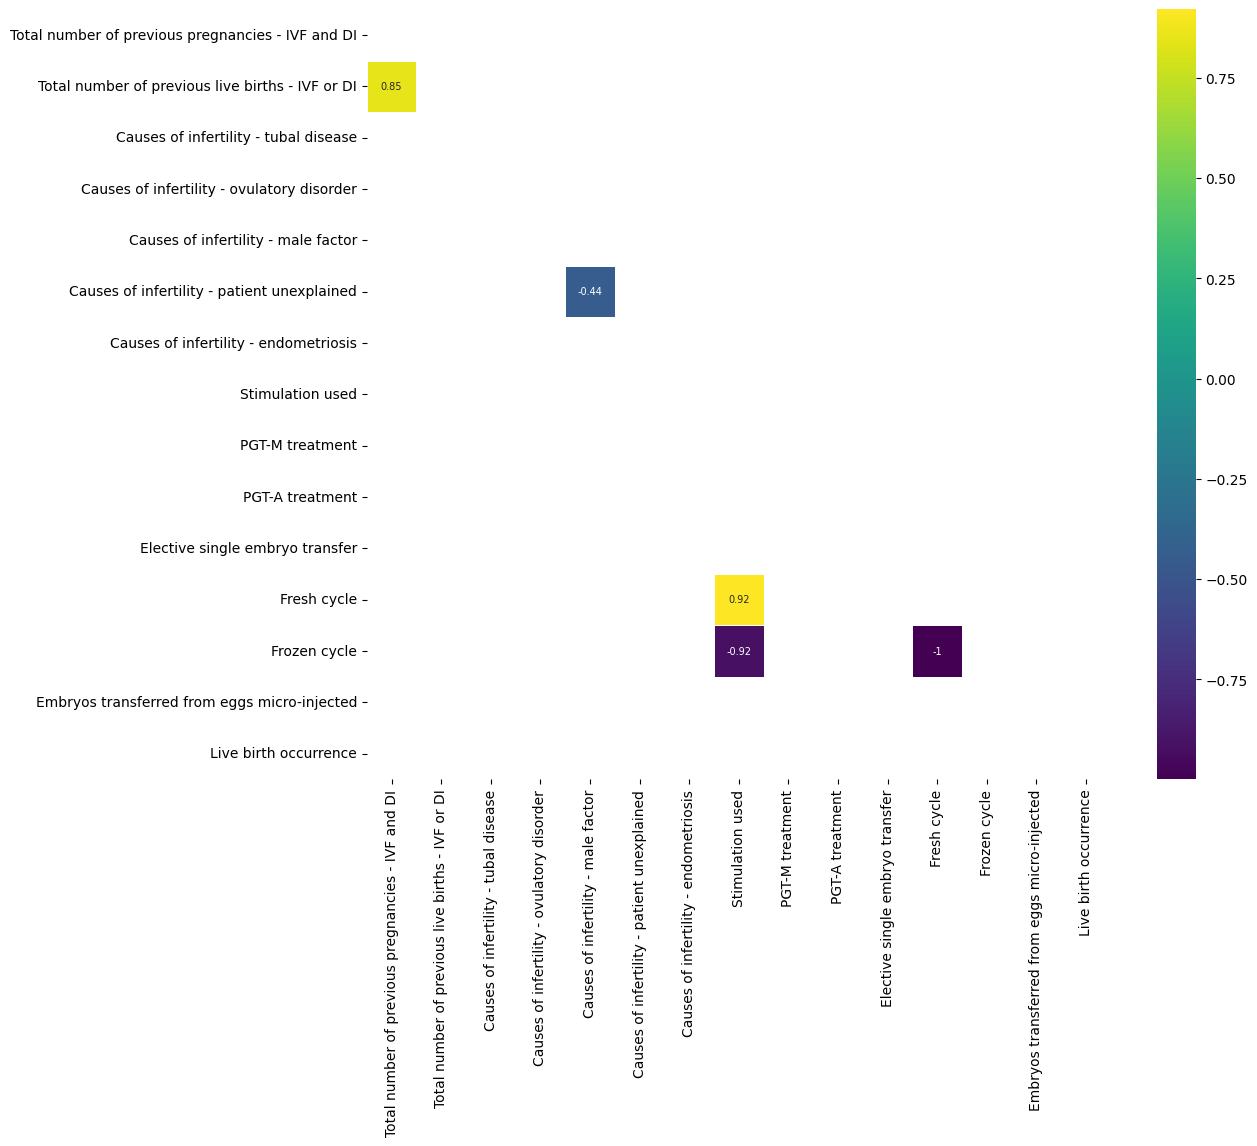



*** Heatmap: Pearson Correlation ***
It evaluates the linear relationship between two continuous variables 



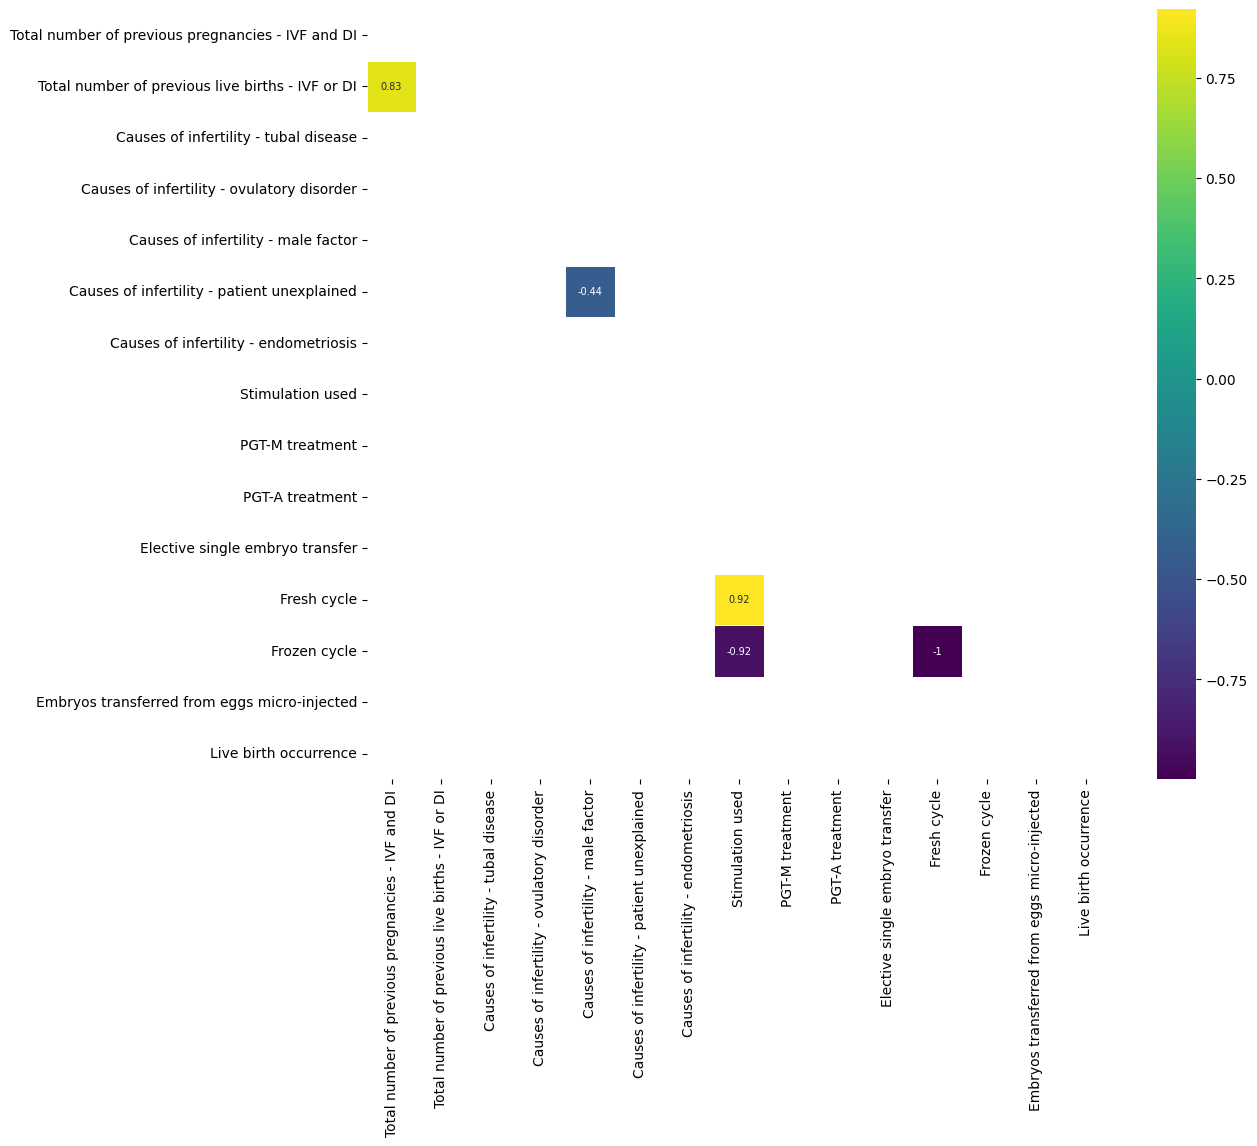



*** Heatmap: Power Predictive Score (PPS) ***
PPS detects linear or non-linear relationships between two columns.
The score ranges from 0 (no predictive power) to 1 (perfect predictive power) 



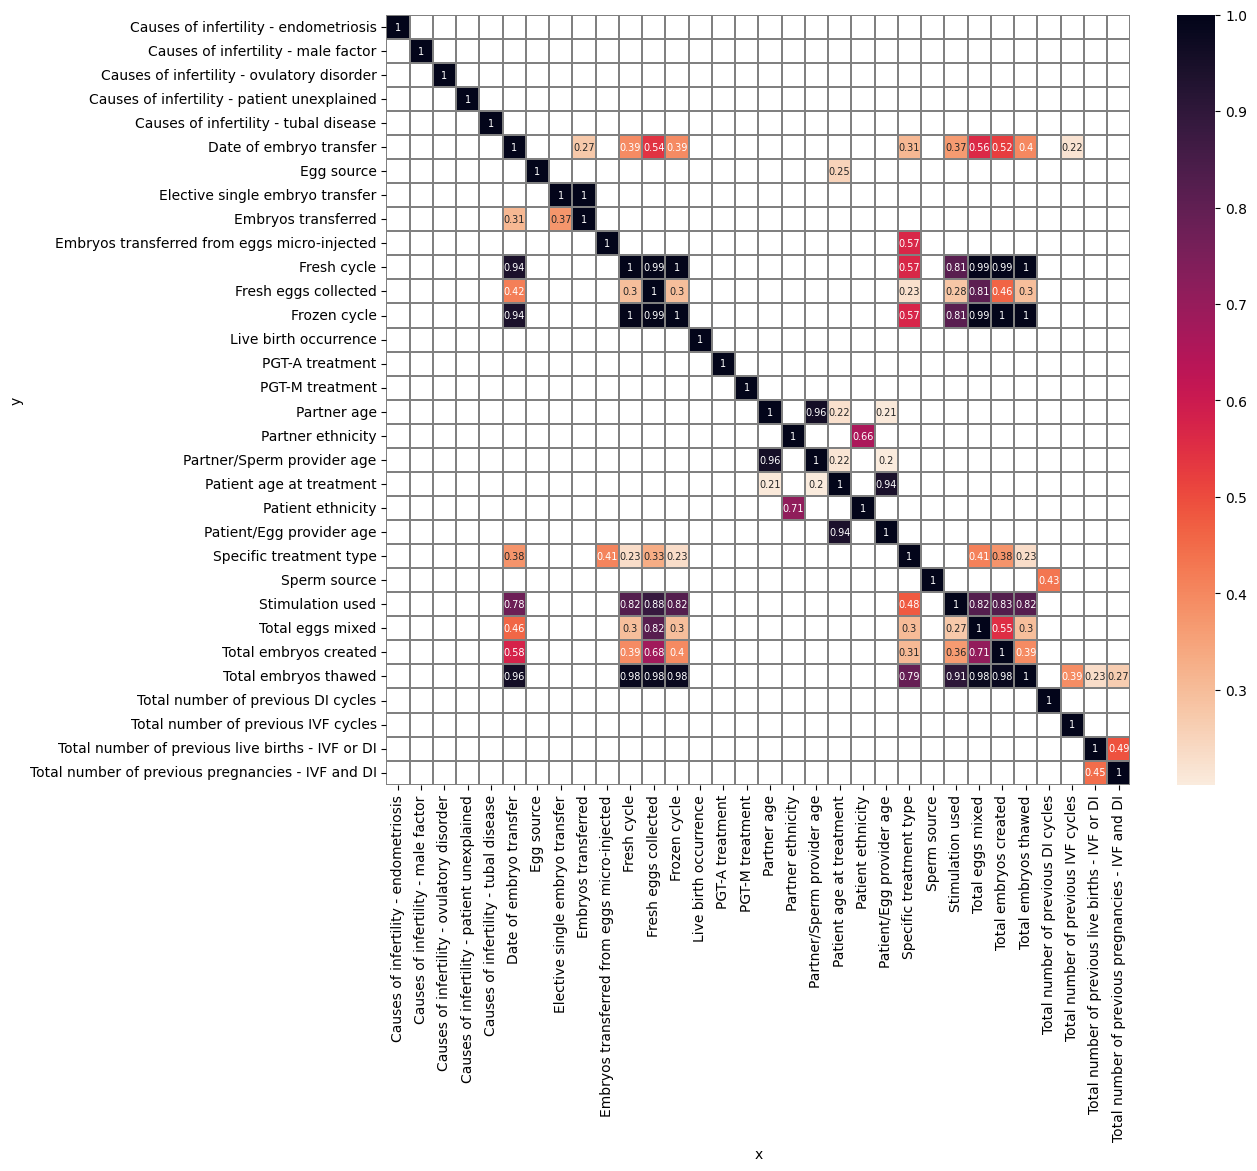

In [7]:
DisplayCorrAndPPS(df_corr_pearson = df_corr_pearson,
                  df_corr_spearman = df_corr_spearman, 
                  pps_matrix = pps_matrix,
                  CorrThreshold = 0.4, PPS_Threshold =0.2,
                  figsize=(12,10), font_annot=7)

---

## Load Train and Test Sets

Tain Set

In [8]:
import pandas as pd
train_set_path = "outputs/datasets/cleaned/TrainSetCleaned.csv"
TrainSet = pd.read_csv(train_set_path)
TrainSet.head(3)

Patient age at treatment Total number of previous IVF cycles  \
0                    38-39                                   3   
1                    18-34                                   0   
2                    38-39                                   2   

  Total number of previous DI cycles  \
0                                  0   
1                                  0   
2                                  0   

   Total number of previous pregnancies - IVF and DI  \
0                                                  0   
1                                                  0   
2                                                  0   

   Total number of previous live births - IVF or DI  \
0                                                 0   
1                                                 0   
2                                                 0   

   Causes of infertility - tubal disease  \
0                                      0   
1                                      0   
2                                      0   

   Causes of infertility - ovulatory disorder  \
0                                           0   
1                                           0   
2                                           0   

   Causes of infertility - male factor  \
0                                    1   
1                                    1   
2                                    0   

   Causes of infertility - patient unexplained  \
0                                            0   
1                                            0   
2                                            1   

   Causes of infertility - endometriosis  ...  Total eggs mixed  \
0                                      0  ...             11-15   
1                                      0  ...               1-5   
2                                      0  ...               1-5   

  Total embryos created Embryos transferred Total embryos thawed  \
0                  6-10                   2      0 - fresh cycle   
1                   1-5                  1e      0 - fresh cycle   
2                     0                   0      0 - fresh cycle   

   Embryos transferred from eggs micro-injected  Date of embryo transfer  \
0                                             2                5 - fresh   
1                                             1                4 - fresh   
2                                             0                       NT   

   Live birth occurrence Patient ethnicity Partner ethnicity  Partner age  
0                      1             White             White        43-44  
1                      0             White             White        18-34  
2                      0             Other             Other        35-37  

[3 rows x 32 columns]

Test Set

In [9]:
test_set_path = 'outputs/datasets/cleaned/TestSetCleaned.csv'
TestSet = pd.read_csv(test_set_path)
TestSet.head(3)

Patient age at treatment Total number of previous IVF cycles  \
0                    38-39                                   3   
1                    18-34                                   0   
2                    38-39                                   2   

  Total number of previous DI cycles  \
0                                  0   
1                                  0   
2                                  0   

   Total number of previous pregnancies - IVF and DI  \
0                                                  0   
1                                                  0   
2                                                  0   

   Total number of previous live births - IVF or DI  \
0                                                 0   
1                                                 0   
2                                                 0   

   Causes of infertility - tubal disease  \
0                                      0   
1                                      0   
2                                      0   

   Causes of infertility - ovulatory disorder  \
0                                           0   
1                                           0   
2                                           0   

   Causes of infertility - male factor  \
0                                    1   
1                                    1   
2                                    0   

   Causes of infertility - patient unexplained  \
0                                            0   
1                                            0   
2                                            1   

   Causes of infertility - endometriosis  ...  Total eggs mixed  \
0                                      0  ...             11-15   
1                                      0  ...               1-5   
2                                      0  ...               1-5   

  Total embryos created Embryos transferred Total embryos thawed  \
0                  6-10                   2      0 - fresh cycle   
1                   1-5                  1e      0 - fresh cycle   
2                     0                   0      0 - fresh cycle   

   Embryos transferred from eggs micro-injected  Date of embryo transfer  \
0                                             2                5 - fresh   
1                                             1                4 - fresh   
2                                             0                       NT   

   Live birth occurrence Patient ethnicity Partner ethnicity  Partner age  
0                      1             White             White        43-44  
1                      0             White             White        18-34  
2                      0             Other             Other        35-37  

[3 rows x 32 columns]

---

## Data Exploration

In [10]:
from ydata_profiling import ProfileReport
pandas_report = ProfileReport(df=TrainSet, minimal=True)
pandas_report.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [11]:
print (f"Number of empty entries followed by the unique values and data type at each column:\n")

for column in TrainSet.columns:
    # Check how many empty fields there are in each column
    empty_fields_count = TrainSet[column].isnull().sum()
    # Check unique values there are in each column
    unique_values = TrainSet[column].unique()
    # Check data type of each column
    data_type = TrainSet[column].dtype
    
    print (f"- {column}: {empty_fields_count}, {unique_values}, {data_type}\n")

Number of empty entries followed by the unique values and data type at each column:

- Patient age at treatment: 0, ['38-39' '18-34' '40-42' '35-37' '43-44' '45-50'], object

- Total number of previous IVF cycles: 0, ['3' '0' '2' '1' '>5' '5' '4'], object

- Total number of previous DI cycles: 0, ['0' '2' '3' '>5' '1' '5' '4'], object

- Total number of previous pregnancies - IVF and DI: 0, [0 1 2 3 4 5], int64

- Total number of previous live births - IVF or DI: 0, [0 1 2 3 4], int64

- Causes of infertility - tubal disease: 0, [0 1], int64

- Causes of infertility - ovulatory disorder: 0, [0 1], int64

- Causes of infertility - male factor: 0, [1 0], int64

- Causes of infertility - patient unexplained: 0, [0 1], int64

- Causes of infertility - endometriosis: 0, [0 1], int64

- Stimulation used: 0, [1 0], int64

- Patient/Egg provider age: 0, ['38-39' '18-34' '40-42' '35-37' '43-44' '45-50'], object

- Partner/Sperm provider age: 0, ['43-44' '18-34' '35-37' '40-42' '45-50' '38-39' '

## Feature Engineering

In [12]:
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings
from feature_engine import transformation as vt
from feature_engine.outliers import Winsorizer
from feature_engine.encoding import OrdinalEncoder
from feature_engine.encoding import OneHotEncoder

sns.set_theme(style="whitegrid")
warnings.filterwarnings('ignore')


def FeatureEngineeringAnalysis(df, analysis_type=None):
    """
    - used for quick feature engineering on numerical and categorical variables
    to decide which transformation can better transform the distribution shape
    - Once transformed, use a reporting tool, like ydata-profiling, to evaluate distributions
    """
    check_missing_values(df)
    allowed_types = ['numerical', 'ordinal_encoder', 'outlier_winsorizer', 'one_hot_encoder']
    check_user_entry_on_analysis_type(analysis_type, allowed_types)
    list_column_transformers = define_list_column_transformers(analysis_type)

    # Loop in each variable and engineer the data according to the analysis type
    df_feat_eng = pd.DataFrame([])
    for column in df.columns:
        # create additional columns (column_method) to apply the methods
        df_feat_eng = pd.concat([df_feat_eng, df[column]], axis=1)
        for method in list_column_transformers:
            df_feat_eng[f"{column}_{method}"] = df[column]

        # Apply transformers in respective column_transformers
        df_feat_eng, list_applied_transformers = apply_transformers(
            analysis_type, df_feat_eng, column)

        # For each variable, assess how the transformations perform
        transformer_evaluation(
            column, list_applied_transformers, analysis_type, df_feat_eng)

    return df_feat_eng


def check_user_entry_on_analysis_type(analysis_type, allowed_types):
    """ Check analysis type """
    if analysis_type is None:
        raise SystemExit(
            f"You should pass analysis_type parameter as one of the following options: {allowed_types}")
    if analysis_type not in allowed_types:
        raise SystemExit(
            f"analysis_type argument should be one of these options: {allowed_types}")


def check_missing_values(df):
    if df.isna().sum().sum() != 0:
        raise SystemExit(
            f"There is a missing value in your dataset. Please handle that before getting into feature engineering.")


def define_list_column_transformers(analysis_type):
    """ Set suffix columns according to analysis_type"""
    if analysis_type == 'numerical':
        list_column_transformers = [
            "log_e", "log_10", "reciprocal", "power", "box_cox", "yeo_johnson"]

    elif analysis_type == 'ordinal_encoder':
        list_column_transformers = ["ordinal_encoder"]

    elif analysis_type == 'outlier_winsorizer':
        list_column_transformers = ['iqr']
    
    elif analysis_type == 'one_hot_encoder':
        list_column_transformers = ["one_hot_encoder"]

    return list_column_transformers


def apply_transformers(analysis_type, df_feat_eng, column):
    for col in df_feat_eng.select_dtypes(include='category').columns:
        df_feat_eng[col] = df_feat_eng[col].astype('object')

    if analysis_type == 'numerical':
        df_feat_eng, list_applied_transformers = FeatEngineering_Numerical(
            df_feat_eng, column)

    elif analysis_type == 'outlier_winsorizer':
        df_feat_eng, list_applied_transformers = FeatEngineering_OutlierWinsorizer(
            df_feat_eng, column)

    elif analysis_type == 'ordinal_encoder':
        df_feat_eng, list_applied_transformers = FeatEngineering_CategoricalEncoder(
            df_feat_eng, column)
    
    elif analysis_type == 'one_hot_encoder':
        df_feat_eng, list_applied_transformers = FeatEngineering_OneHotEncoder(
            df_feat_eng, column)

    return df_feat_eng, list_applied_transformers


def transformer_evaluation(column, list_applied_transformers, analysis_type, df_feat_eng):
    # For each variable, assess how the transformations perform
    print(f"* Variable Analyzed: {column}")
    print(f"* Applied transformation: {list_applied_transformers} \n")
    
    if analysis_type == 'one_hot_encoder':
        # For one-hot encoding, the original column is replaced with multiple columns.
        for col in list_applied_transformers:
            DiagnosticPlots_Categories(df_feat_eng, col)
    else:
        for col in [column] + list_applied_transformers:
            if analysis_type != 'ordinal_encoder':
                DiagnosticPlots_Numerical(df_feat_eng, col)
            else:
                if col == column:
                    DiagnosticPlots_Categories(df_feat_eng, col)
                else:
                    DiagnosticPlots_Numerical(df_feat_eng, col)

    print("\n")



def DiagnosticPlots_Categories(df_feat_eng, col):
    plt.figure(figsize=(4, 3))
    sns.countplot(data=df_feat_eng, x=col, palette=[
                  '#432371'], order=df_feat_eng[col].value_counts().index)
    plt.xticks(rotation=90)
    plt.suptitle(f"{col}", fontsize=30, y=1.05)
    plt.show()
    print("\n")


def DiagnosticPlots_Numerical(df, variable):
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    sns.histplot(data=df, x=variable, kde=True, element="step", ax=axes[0])
    stats.probplot(df[variable], dist="norm", plot=axes[1])
    sns.boxplot(x=df[variable], ax=axes[2])

    axes[0].set_title('Histogram')
    axes[1].set_title('QQ Plot')
    axes[2].set_title('Boxplot')
    fig.suptitle(f"{variable}", fontsize=30, y=1.05)
    plt.tight_layout()
    plt.show()


def FeatEngineering_CategoricalEncoder(df_feat_eng, column):
    list_methods_worked = []
    try:
        encoder = OrdinalEncoder(encoding_method='arbitrary', variables=[
                                 f"{column}_ordinal_encoder"])
        df_feat_eng = encoder.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_ordinal_encoder")

    except Exception:
        df_feat_eng.drop([f"{column}_ordinal_encoder"], axis=1, inplace=True)

    return df_feat_eng, list_methods_worked


def FeatEngineering_OutlierWinsorizer(df_feat_eng, column):
    list_methods_worked = []

    # Winsorizer iqr
    try:
        disc = Winsorizer(
            capping_method='iqr', tail='both', fold=1.5, variables=[f"{column}_iqr"])
        df_feat_eng = disc.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_iqr")
    except Exception:
        df_feat_eng.drop([f"{column}_iqr"], axis=1, inplace=True)

    return df_feat_eng, list_methods_worked


def FeatEngineering_Numerical(df_feat_eng, column):
    list_methods_worked = []

    # LogTransformer base e
    try:
        lt = vt.LogTransformer(variables=[f"{column}_log_e"])
        df_feat_eng = lt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_log_e")
    except Exception:
        df_feat_eng.drop([f"{column}_log_e"], axis=1, inplace=True)

    # LogTransformer base 10
    try:
        lt = vt.LogTransformer(variables=[f"{column}_log_10"], base='10')
        df_feat_eng = lt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_log_10")
    except Exception:
        df_feat_eng.drop([f"{column}_log_10"], axis=1, inplace=True)

    # ReciprocalTransformer
    try:
        rt = vt.ReciprocalTransformer(variables=[f"{column}_reciprocal"])
        df_feat_eng = rt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_reciprocal")
    except Exception:
        df_feat_eng.drop([f"{column}_reciprocal"], axis=1, inplace=True)

    # PowerTransformer
    try:
        pt = vt.PowerTransformer(variables=[f"{column}_power"])
        df_feat_eng = pt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_power")
    except Exception:
        df_feat_eng.drop([f"{column}_power"], axis=1, inplace=True)

    # BoxCoxTransformer
    try:
        bct = vt.BoxCoxTransformer(variables=[f"{column}_box_cox"])
        df_feat_eng = bct.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_box_cox")
    except Exception:
        df_feat_eng.drop([f"{column}_box_cox"], axis=1, inplace=True)

    # YeoJohnsonTransformer
    try:
        yjt = vt.YeoJohnsonTransformer(variables=[f"{column}_yeo_johnson"])
        df_feat_eng = yjt.fit_transform(df_feat_eng)
        list_methods_worked.append(f"{column}_yeo_johnson")
    except Exception:
        df_feat_eng.drop([f"{column}_yeo_johnson"], axis=1, inplace=True)

    return df_feat_eng, list_methods_worked



def FeatEngineering_OneHotEncoder(df_feat_eng, column):
    list_methods_worked = []
    try:
        # Initialize the OneHotEncoder from feature_engine
        encoder = OneHotEncoder(drop_last=True, variables=[column])
        
        # Fit and transform the dataframe
        df_feat_eng = encoder.fit_transform(df_feat_eng)
        
        # Record the applied transformations
        encoded_columns = df_feat_eng.columns[df_feat_eng.columns.str.startswith(column)]
        list_methods_worked.extend(encoded_columns)
    
    except Exception as e:
        print(f"Error with column {column}: {e}")
        if any(f"{column}_" in col for col in df_feat_eng.columns):
            columns_to_drop = [col for col in df_feat_eng.columns if f"{column}_" in col]
            df_feat_eng.drop(columns=columns_to_drop, axis=1, inplace=True)
    
    return df_feat_eng, list_methods_worked


## Transformers

* Categorical Encoding (OrdinalEncoder and OneHotEncoder)
* Smart Correlation Selection (SmartCorrelatedSelection)

#### Categorical Encoding - Ordinal: replaces categories with ordinal numbers. For features where the order of categories is important

Select variables

In [13]:
variables_eng_oe= [
        'Patient age at treatment',
        'Partner/Sperm provider age',
        'Patient/Egg provider age',
        'Total number of previous IVF cycles',
        'Total number of previous DI cycles',
        'Fresh eggs collected',
        'Total eggs mixed',
        'Total embryos created',
        'Embryos transferred',
        'Total embryos thawed',
        'Date of embryo transfer',
        'Partner age'
        ]

variables_eng_oe

['Patient age at treatment',
 'Partner/Sperm provider age',
 'Patient/Egg provider age',
 'Total number of previous IVF cycles',
 'Total number of previous DI cycles',
 'Fresh eggs collected',
 'Total eggs mixed',
 'Total embryos created',
 'Embryos transferred',
 'Total embryos thawed',
 'Date of embryo transfer',
 'Partner age']

Create a separate DataFrame with the selected variables

In [14]:
df_eng_oe = TrainSet[variables_eng_oe].copy()
df_eng_oe.head(3)

Patient age at treatment Partner/Sperm provider age  \
0                    38-39                      43-44   
1                    18-34                      18-34   
2                    38-39                      35-37   

  Patient/Egg provider age Total number of previous IVF cycles  \
0                    38-39                                   3   
1                    18-34                                   0   
2                    38-39                                   2   

  Total number of previous DI cycles Fresh eggs collected Total eggs mixed  \
0                                  0                16-20            11-15   
1                                  0                 6-10              1-5   
2                                  0                  1-5              1-5   

  Total embryos created Embryos transferred Total embryos thawed  \
0                  6-10                   2      0 - fresh cycle   
1                   1-5                  1e      0 - fresh cycle   
2                     0                   0      0 - fresh cycle   

  Date of embryo transfer Partner age  
0               5 - fresh       43-44  
1               4 - fresh       18-34  
2                      NT       35-37

Apply the transformation

* Variable Analyzed: Patient age at treatment
* Applied transformation: ['Patient age at treatment_ordinal_encoder'] 



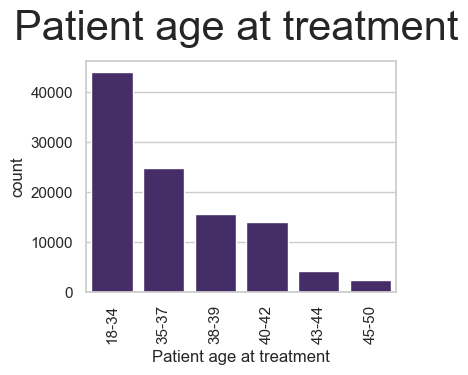

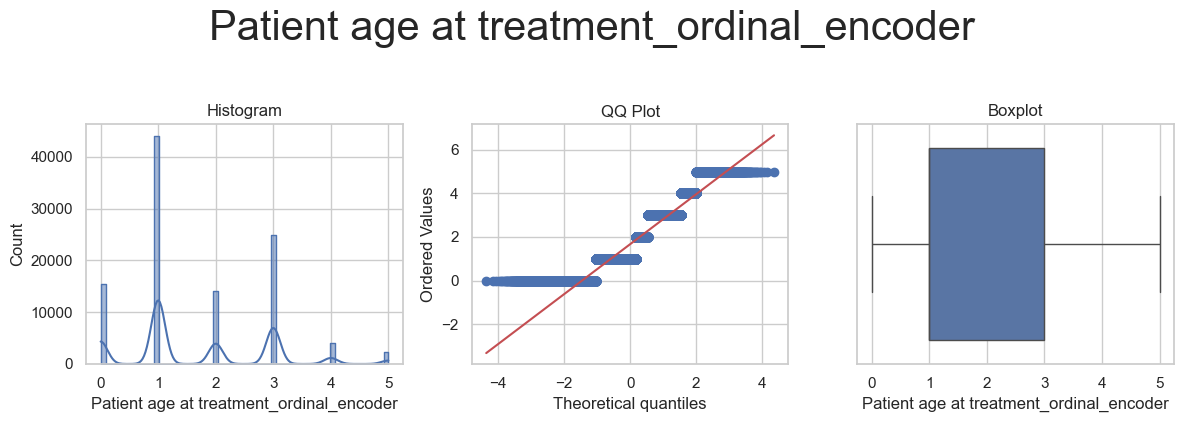



* Variable Analyzed: Partner/Sperm provider age
* Applied transformation: ['Partner/Sperm provider age_ordinal_encoder'] 



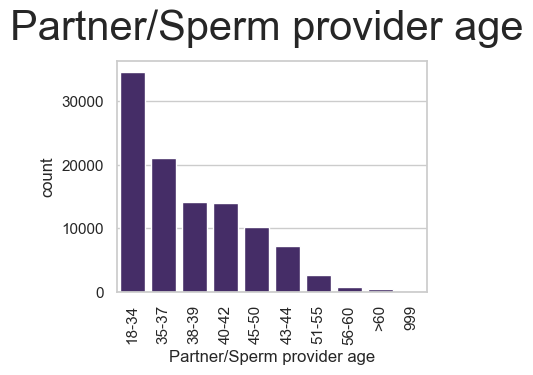

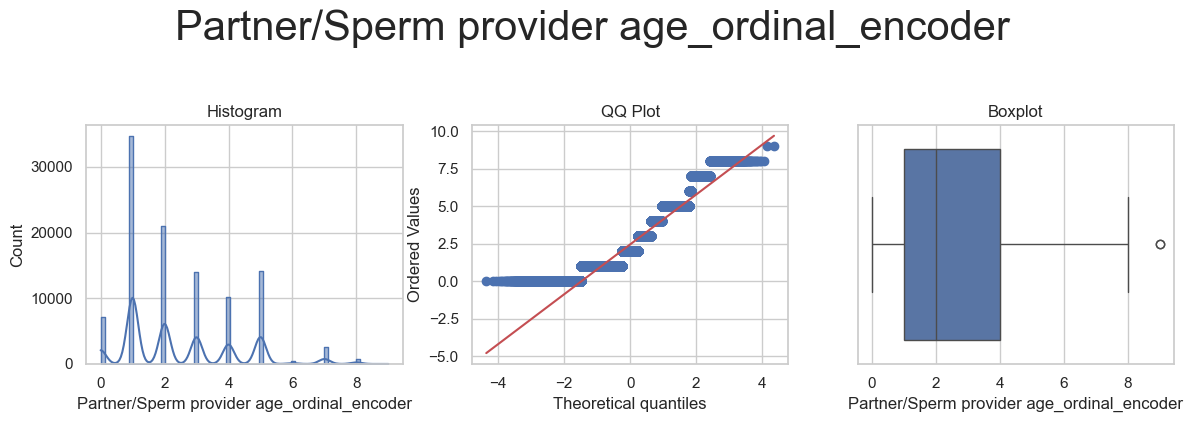



* Variable Analyzed: Patient/Egg provider age
* Applied transformation: ['Patient/Egg provider age_ordinal_encoder'] 



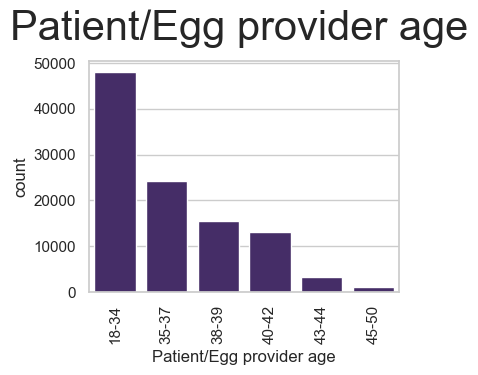

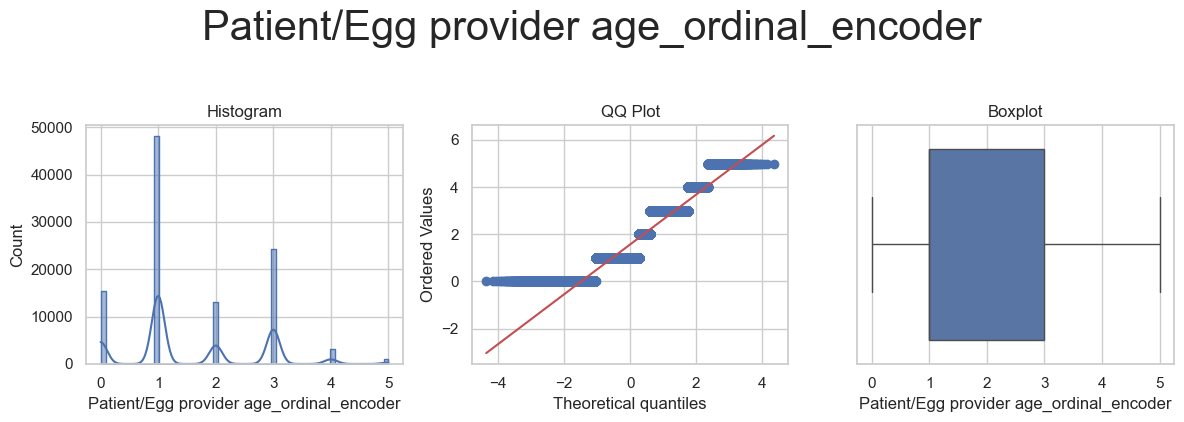



* Variable Analyzed: Total number of previous IVF cycles
* Applied transformation: ['Total number of previous IVF cycles_ordinal_encoder'] 



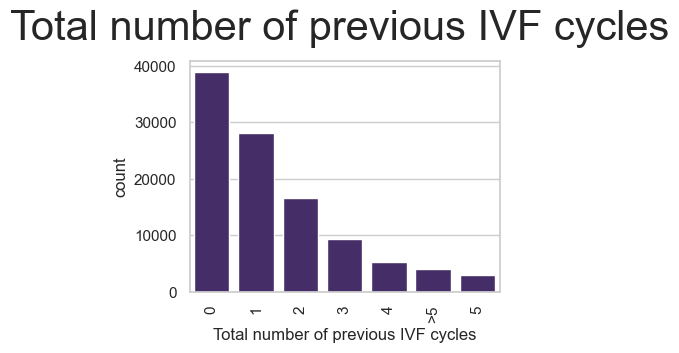

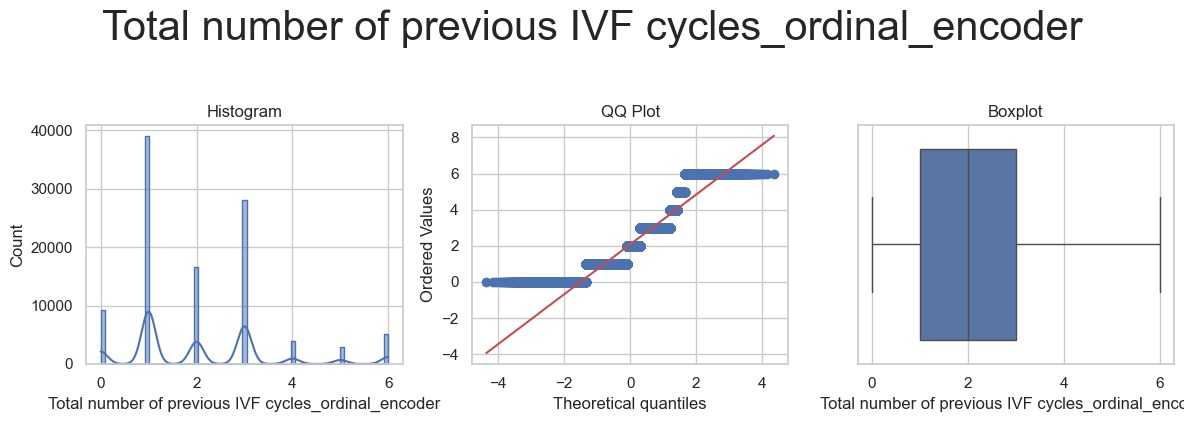



* Variable Analyzed: Total number of previous DI cycles
* Applied transformation: ['Total number of previous DI cycles_ordinal_encoder'] 



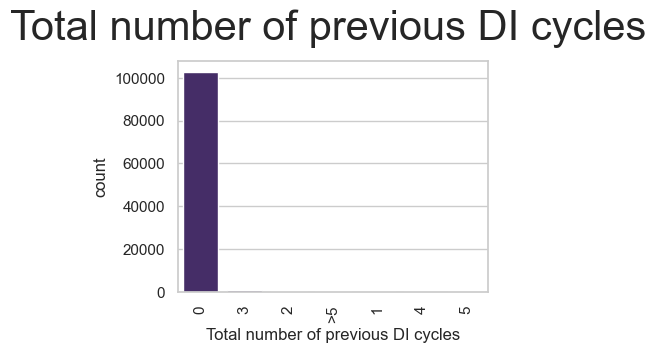

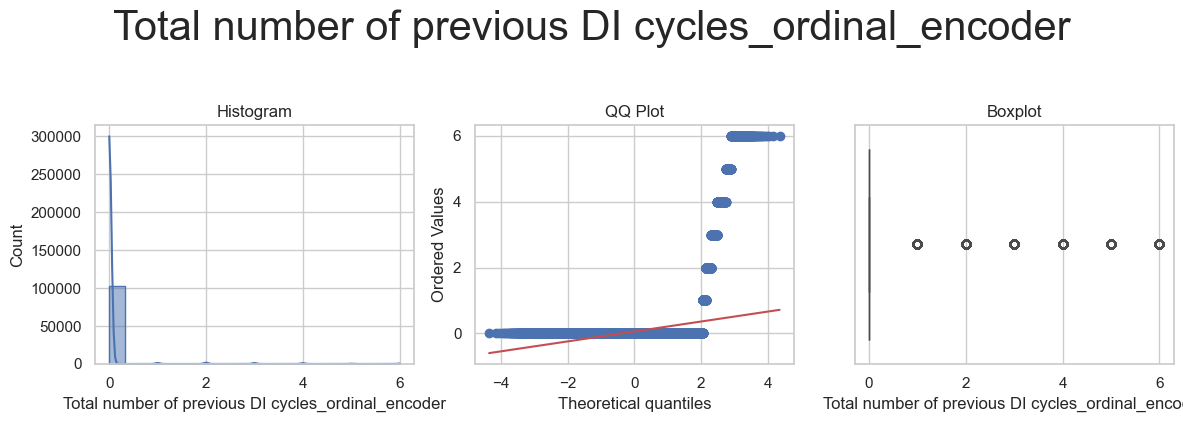



* Variable Analyzed: Fresh eggs collected
* Applied transformation: ['Fresh eggs collected_ordinal_encoder'] 



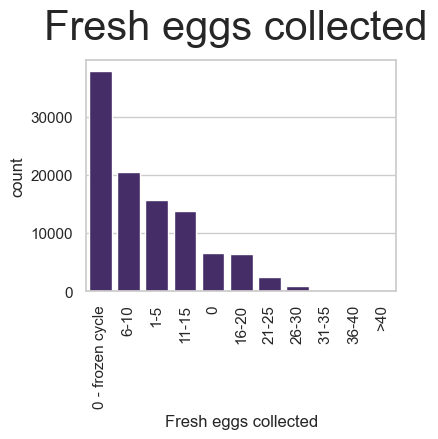

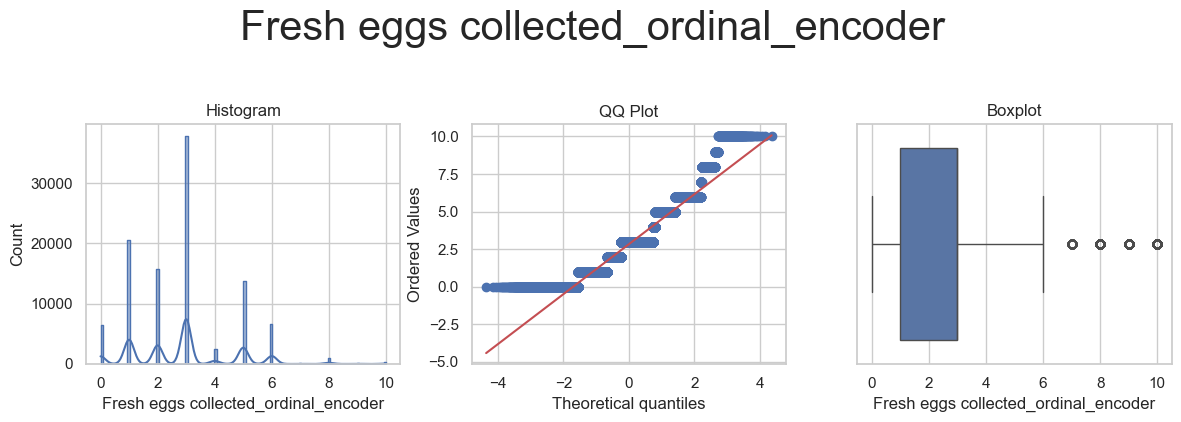



* Variable Analyzed: Total eggs mixed
* Applied transformation: ['Total eggs mixed_ordinal_encoder'] 



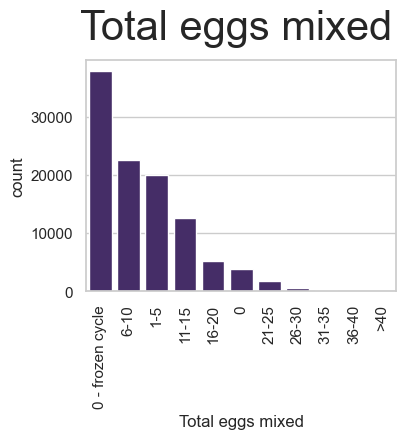

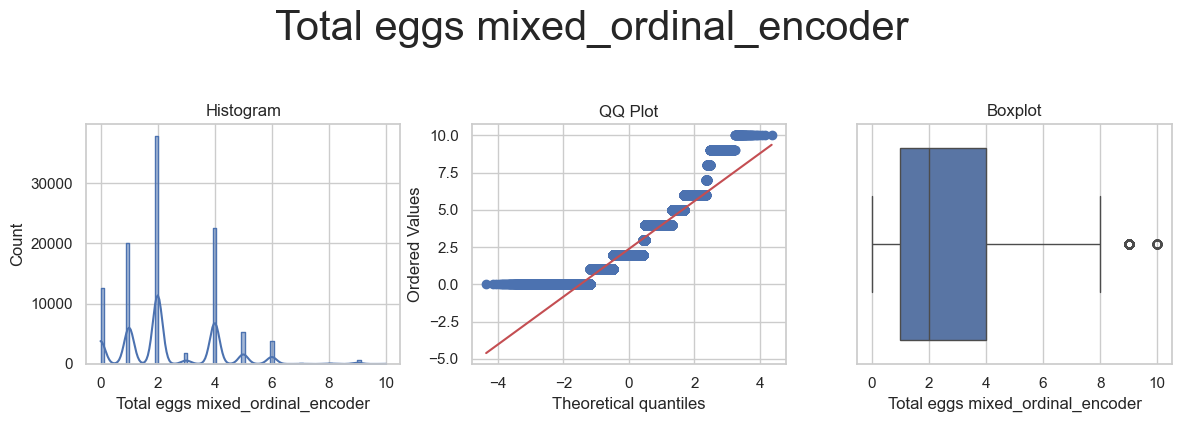



* Variable Analyzed: Total embryos created
* Applied transformation: ['Total embryos created_ordinal_encoder'] 



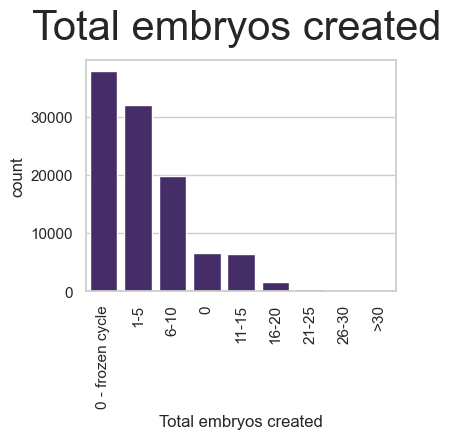

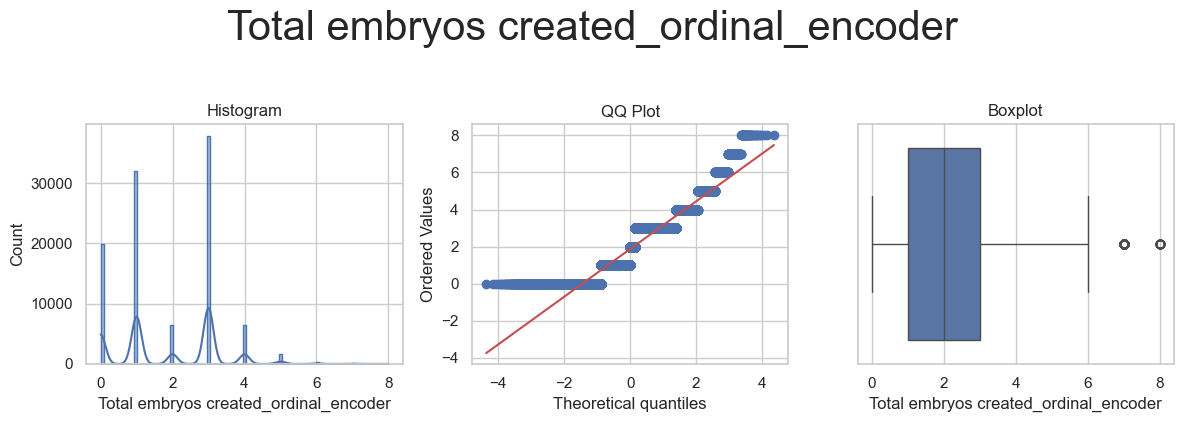



* Variable Analyzed: Embryos transferred
* Applied transformation: ['Embryos transferred_ordinal_encoder'] 



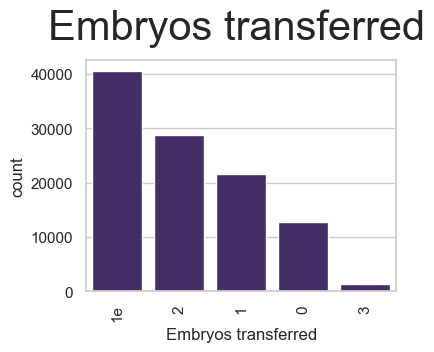

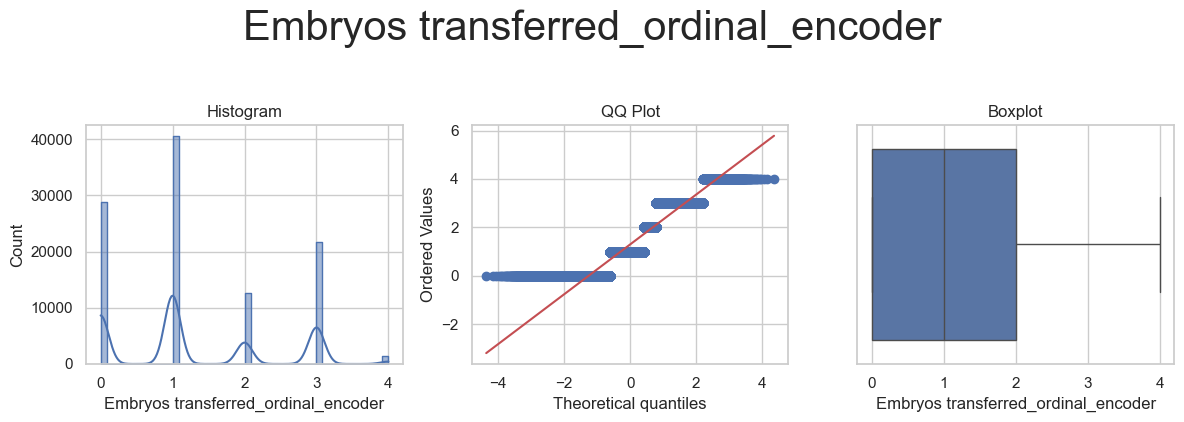



* Variable Analyzed: Total embryos thawed
* Applied transformation: ['Total embryos thawed_ordinal_encoder'] 



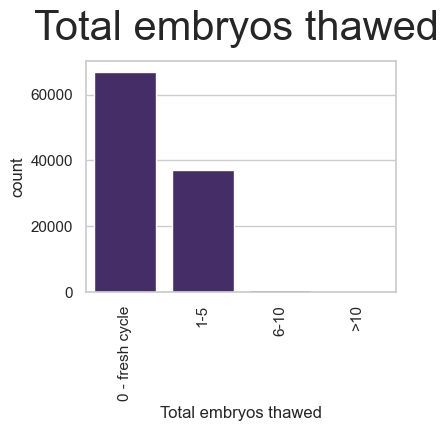

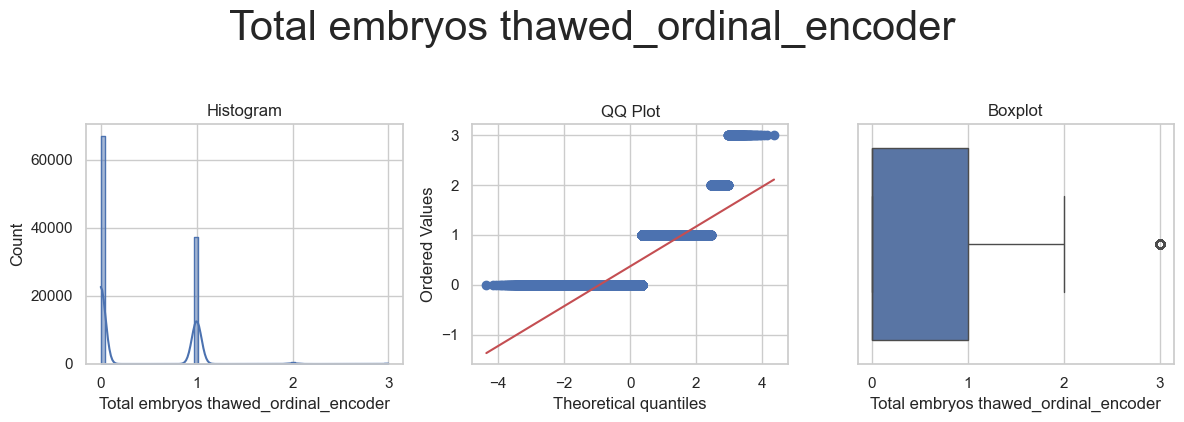



* Variable Analyzed: Date of embryo transfer
* Applied transformation: ['Date of embryo transfer_ordinal_encoder'] 



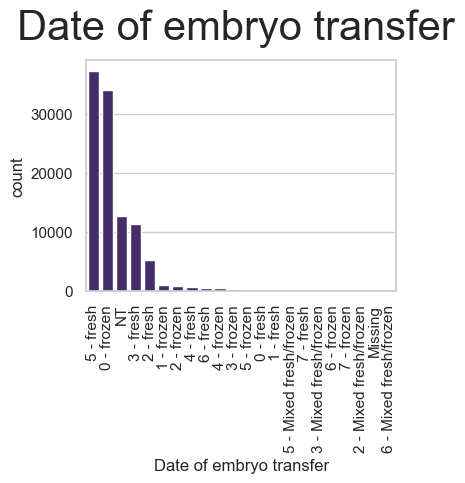

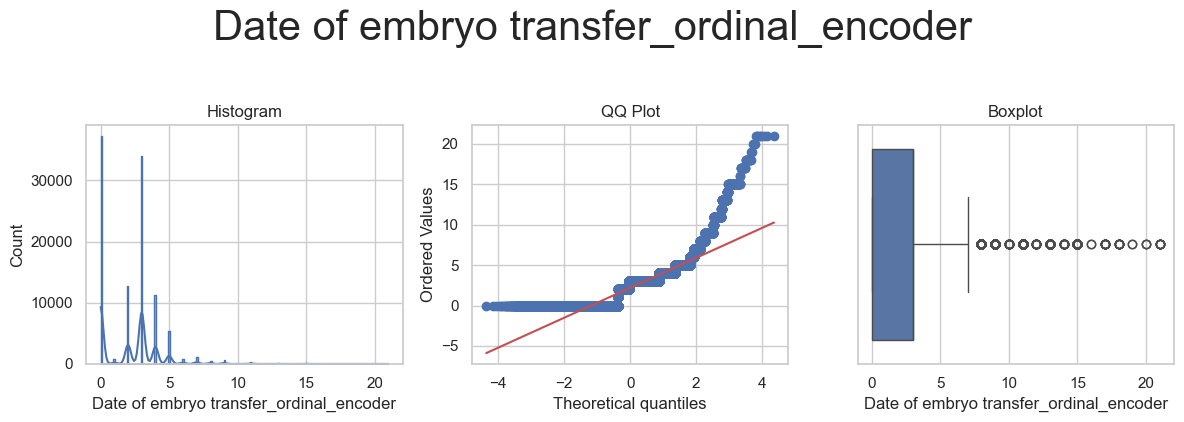



* Variable Analyzed: Partner age
* Applied transformation: ['Partner age_ordinal_encoder'] 



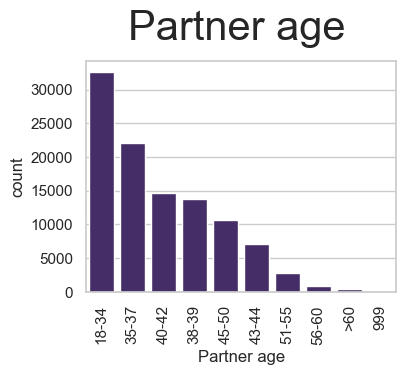

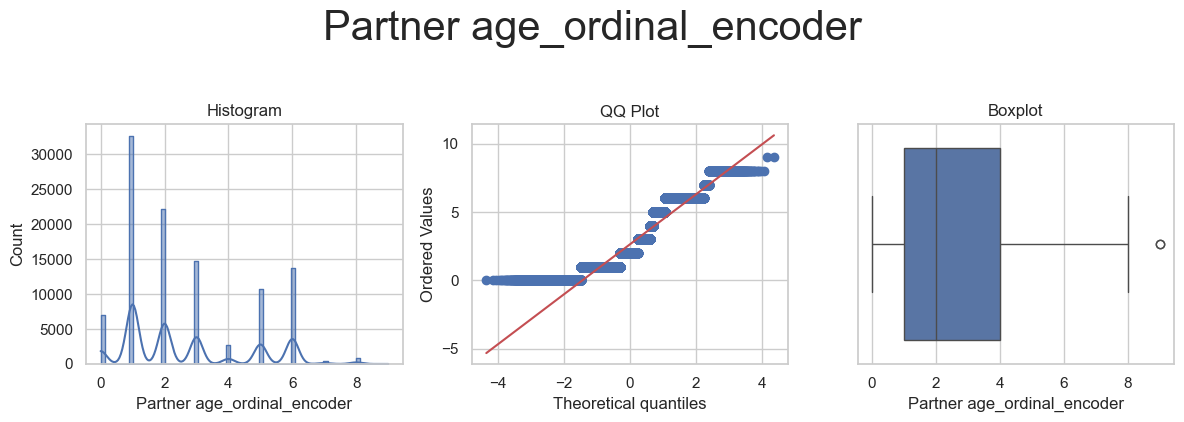

In [15]:
df_eng_oe = FeatureEngineeringAnalysis(df=df_eng_oe, analysis_type='ordinal_encoder')

Conclusion on how the transformation(s) look to be effective:
  * For all variables, the transformation is effective, since it converted categories to numbers.

Apply the selected transformation to the Train and Test Set

In [16]:
ordinal_encoder = OrdinalEncoder(encoding_method='arbitrary', variables = variables_eng_oe)
TrainSet = ordinal_encoder.fit_transform(TrainSet)
TestSet = ordinal_encoder.transform(TestSet)

print("* Categorical encoding - ordinal transformation done!")

* Categorical encoding - ordinal transformation done!



#### OneHotEncoder for features without inherent order:

Select variables

In [17]:
variables_eng_ohe= [
        'Specific treatment type',
        'Egg source',
        'Sperm source',
        'Patient ethnicity',
        'Partner ethnicity'
        ]

variables_eng_ohe

['Specific treatment type',
 'Egg source',
 'Sperm source',
 'Patient ethnicity',
 'Partner ethnicity']

Create a separate DataFrame with the selected variables

In [18]:
df_eng_ohe = TrainSet[variables_eng_ohe].copy()
df_eng_ohe.head(3)

Specific treatment type Egg source Sperm source Patient ethnicity  \
0                    ICSI    Patient      Partner             White   
1                    ICSI    Patient      Partner             White   
2                     IVF    Patient      Partner             Other   

  Partner ethnicity  
0             White  
1             White  
2             Other

Apply the transformation

* Variable Analyzed: Specific treatment type
* Applied transformation: ['Specific treatment type_one_hot_encoder', 'Specific treatment type_ICSI', 'Specific treatment type_IVF', 'Specific treatment type_Unknown', 'Specific treatment type_ICSI:IVF', 'Specific treatment type_ICSI:Unknown'] 



ValueError: Could not interpret value `Specific treatment type` for `x`. An entry with this name does not appear in `data`.

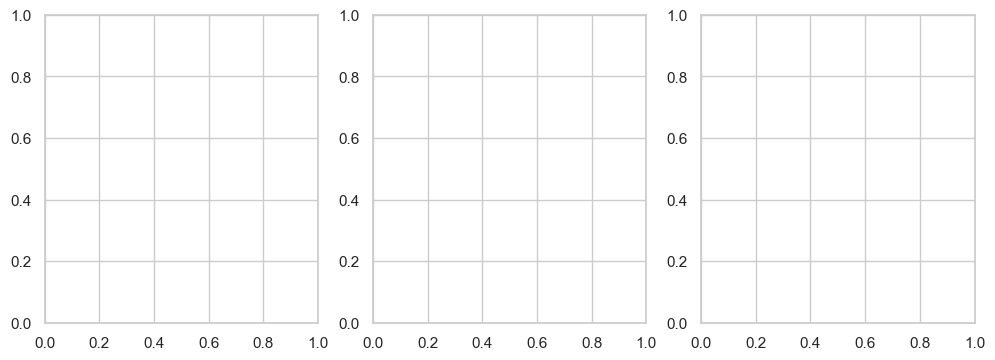

In [19]:
df_eng_ohe = FeatureEngineeringAnalysis(df=df_eng_ohe, analysis_type='one_hot_encoder')


Conclusion on how the transformation(s) look to be effective:
  * For all variables, the transformation is effective, since it converted categories to numbers.

Apply the selected transformation to the Train and Test Set

In [ ]:
ohe_encoder = OneHotEncoder(top_categories=None, drop_last=True, variables = variables_eng_ohe)
TrainSet = ohe_encoder.fit_transform(TrainSet)
TestSet = ohe_encoder.transform(TestSet)

print("* One Hot Encoding - transformation done!")